# Movie Recommendation by ALS Algorithm
* Using Alternating Least Sqaure (ALS) with Spark APIs to predict the ratings for movies
##Content
* Import Data  and Set Up Environment
* Recomendation Model Training based ALS 
* Conclusions

In [ ]:
# # Download Java Virtual Machine (JVM)
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # Download Spark
# !wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# # Unzip the file
# !tar xf spark-3.2.1-bin-hadoop3.2.tgz


# Install pyspark
!pip install pyspark
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 48 kB/s 
     |████████████████████████████████| 199 kB 60.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d16797cb80ac79f2f3d988b2c7721f1fc4a2f4849ee54d16d282261439741017
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Data/ml-latest-small

/content/drive/MyDrive/Data/ml-latest-small


In [ ]:
movies_df = spark.read.load("drive/MyDrive/Data/ml-latest-small/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/Data/ml-latest-small/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/Data/ml-latest-small/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/Data/ml-latest-small/tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(2)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
|      2|  Jumanji (1995)|Adventure|Childre...|
+-------+----------------+--------------------+
only showing top 2 rows



In [ ]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


## OLAP using Spark SQL

In [ ]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
# How many distinct users
distinct_users = spark.sql('select count(distinct userId) as Number_of_Users from ratings')
distinct_users.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



In [ ]:
# # How many moviews
movie_num = spark.sql('Select Count(movieId) as Num_of_Movie from movies')
movie_num.show()

+------------+
|Num_of_Movie|
+------------+
|        9742|
+------------+



In [ ]:
# Movies rated by users
rated_movies = spark.sql('Select count(movieId) as Num_of_Rated_Movies From movies Where movieId in (Select movieId from ratings)') 
rated_movies.show()

+-------------------+
|Num_of_Rated_Movies|
+-------------------+
|               9724|
+-------------------+



In [ ]:
# Movie has not been rated before
unrated_list= spark.sql('Select * From movies Where movieId not in( Select movieId from ratings)')
unrated_list.show(2)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
+-------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
# Check movie genre categories and the number of movies for each category
genre_count = spark.sql("Select genres, count(movieId) as Num_of_Movies From (Select explode(split(genres,'[|]')) as genres, movieId From movies) Group by 1 Order By 2 DESC") 
genre_count.show()

+------------------+-------------+
|            genres|Num_of_Movies|
+------------------+-------------+
|             Drama|         4361|
|            Comedy|         3756|
|          Thriller|         1894|
|            Action|         1828|
|           Romance|         1596|
|         Adventure|         1263|
|             Crime|         1199|
|            Sci-Fi|          980|
|            Horror|          978|
|           Fantasy|          779|
|          Children|          664|
|         Animation|          611|
|           Mystery|          573|
|       Documentary|          440|
|               War|          382|
|           Musical|          334|
|           Western|          167|
|              IMAX|          158|
|         Film-Noir|           87|
|(no genres listed)|           34|
+------------------+-------------+



In [ ]:
# Select all movies for each category
movies_of_category = spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movie from (select explode(split(genres,'[|]')) as genres, title from movies ) group by 1 ")
movies_of_category.show()

+------------------+--------------------+
|            genres|       list_of_movie|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

## Recomendation Model Training based ALS 

### Data Preparation

In [ ]:
ratings_df.show(2)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
+------+-------+------+---------+
only showing top 2 rows



In [ ]:
movie_ratings= ratings_df.drop('Timestamp')
movie_ratings.show(2)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
+------+-------+------+
only showing top 2 rows



In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

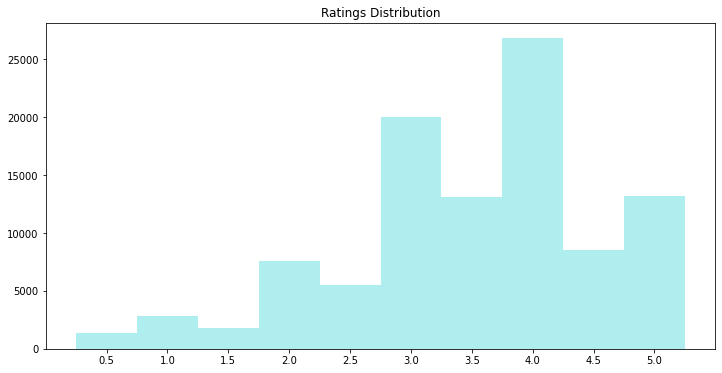

In [ ]:
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5, color = 'paleturquoise')
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

### Model Selction and Evaluation

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
(training,test) = movie_ratings.randomSplit([0.8,0.2])
model_als = ALS(maxIter=10, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6)  # recommmend top 10 movies

In [ ]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")


# Build Cross validation 
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [ ]:
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 25
-> alpha: 0.1


In [ ]:
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.4846008640817872


### Model Testing

In [ ]:
#Generate predictions using test dataset and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.8776632453653889
**Best Model**
 Rank:  25
 MaxIter:  10
 RegParam:  0.1


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   580|   1580|   4.0| 3.5430467|
|   155|   1580|   4.0| 3.8583603|
|    34|   3997|   2.0|  1.609463|
|   368|   1580|   3.0| 3.1434987|
|   115|   1580|   4.0| 3.8744109|
|   385|    471|   4.0| 3.1450174|
|    28|   1645|   2.5| 2.8102806|
|   332|   1645|   3.5| 3.0710742|
|    91|   1645|   3.0| 3.5245764|
|   409|    471|   3.0| 3.7689362|
|    93|   1591|   4.0| 3.0997372|
|   232|   3175|   2.5| 3.2381122|
|   367|   1580|   4.0| 3.5205662|
|   599|   1342|   2.5| 2.2449665|
|   599|   1580|   3.0| 2.7812226|
|   599|   2366|   3.0| 2.8544083|
|   599|   7340|   2.0| 1.9516268|
|   599|   7982|   3.5| 3.2052364|
|   111|   1088|   3.0| 3.0253532|
|   416|   1580|   2.0| 1.1390641|
+------+-------+------+----------+
only showing top 20 rows



### Results

In [ ]:
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.5818189369263672


In [ ]:
alldata.registerTempTable("alldata")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Recommend Top 10 Movies for a Users

In [ ]:
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out
# top 10 for user 575
topKRecommend(10,575,bestModel)

,movieId,title,genres,predicted_ratings
1,51931,Reign Over Me (2007),Drama,5.128338
2,78836,Enter the Void (2009),Drama,4.848960
3,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,4.847374
4,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.819134
5,1366,"Crucible, The (1996)",Drama,4.773477
6,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.772729
7,7096,Rivers and Tides (2001),Documentary,4.757705
8,430,Calendar Girl (1993),Comedy|Drama,4.754154
9,1258,"Shining, The (1980)",Horror,4.719833
10,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.712174


In [ ]:
topKRecommend(10,100,bestModel)

,movieId,title,genres,predicted_ratings
1,7121,Adam's Rib (1949),Comedy|Romance,4.687445
2,4041,"Officer and a Gentleman, An (1982)",Drama|Romance,4.682848
3,74282,Anne of Green Gables: The Sequel (a.k.a. Anne ...,Children|Drama|Romance,4.634639
4,912,Casablanca (1942),Drama|Romance,4.629933
5,1704,Good Will Hunting (1997),Drama|Romance,4.624733
6,33649,Saving Face (2004),Comedy|Drama|Romance,4.607674
7,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller,4.600989
8,5690,Grave of the Fireflies (Hotaru no haka) (1988),Animation|Drama|War,4.594429
9,3022,"General, The (1926)",Comedy|War,4.589661
10,170705,Band of Brothers (2001),Action|Drama|War,4.572069


In [ ]:
topKRecommend(10,125,bestModel)

,movieId,title,genres,predicted_ratings
1,86721,Idiots and Angels (2008),Animation|Drama|Fantasy,4.918718
2,5088,"Going Places (Valseuses, Les) (1974)",Comedy|Crime|Drama,4.918718
3,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,4.813824
4,7008,Last Tango in Paris (Ultimo tango a Parigi) (1...,Drama|Romance,4.808383
5,7387,Dawn of the Dead (1978),Action|Drama|Horror,4.730877
6,9010,Love Me If You Dare (Jeux d'enfants) (2003),Drama|Romance,4.724749
7,58301,Funny Games U.S. (2007),Drama|Thriller,4.724197
8,106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama,4.711364
9,8254,Arizona Dream (1993),Comedy|Drama|Fantasy|Romance,4.707115
10,42632,Lady Vengeance (Sympathy for Lady Vengeance) (...,Crime|Drama|Mystery|Thriller,4.697248


## Conclusions
* A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model (or based on a user's previous records)


* System retrains ALS model on data with the new inputs
System creates movie data for inference (in this case, we sample all movies from the data)


* System make rating predictions on all movies for that user


* System outputs top N movie recommendations for that user based on the ranking of movie rating predictions